# Prediction of User Reactions
We want to predict:
* How to get high score/consensus (upvotes - downvotes)
* How to be controversial (upvotes + downvotes)  
in the comments.

### Import data

In [33]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_09.csv')
df_com = pd.read_csv('comments_2017_09.csv').sample(250000) # crop because battery life, skews data
# Make float better readable
pd.options.display.float_format = '{:.3f}'.format

### Prepare features

In [34]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return (get_dt_obj(time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['time_since_epoch'] = df_com['time'].apply(time_since_epoch)
df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
#df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['con_num_words'] = df_com['con'].apply(lambda x: len(x.split()))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
df_art['cat_copy'] = df_art['cat']
df_art = pd.get_dummies(df_art, columns=['cat'])

df_art['header_len'] = df_art['header'].apply(lambda x: len(x))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))
df_art['text_num_words'] = df_art['text'].apply(lambda x: len(str(x).split()))

# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# is empty: (= all comments correspond to an article)
print(len(df_merge[pd.isnull(df_merge['tit'])]))
df_merge = df_merge[pd.notnull(df_merge['tit'])]

# Get order of comments per article
df_merge_art = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')
# Get time since the first comment
def get_time_since_first(group):
    first = group.iloc[:1]['time_since_epoch']
    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
    # Remove those very late comments, after x hours
    #group = group[group['time_since_first'] < 36]
    return group

df_merge_art = df_merge_art.apply(get_time_since_first)
print(df_merge_art.head(3))

6
             tId  cId  mob  vup  vdo                      tit        aut  \
250203  10003016  1_1    1  602   30  die spitze des eisbergs  Mani Motz   
250202  10003016  5_5    1  149   39                    fake?     Müller   
250211  10003016  7_7    1  503   37              abscheulich      Pitri   

                       time  \
250203  am 08.08.2017 07:34   
250202  am 08.08.2017 07:38   
250211  am 08.08.2017 07:39   

                                                      con  time_since_epoch  \
250203               erschreckend was alles möglich ist.     1502177640.000   
250202   im text wird erwähnt das black death angebote...    1502177880.000   
250211   was sind das nur für kreaturen. sorry, ich ka...    1502177940.000   

              ...         cat_people  cat_play  cat_playview  cat_schweiz  \
250203        ...                  0         0             0            0   
250202        ...                  0         0             0            0   
250211        ...   

### Trying to remove skew
__Rescaling__: Add or subtract a constant and then multiply or divide by a constant.  
__Normalizing__: Dividing by a norm of the vector, e.g. make Euclidean length equal to one. Sometimes make all elements lie in [0, 1].  
__Standardizing__: Subtracting a measure of location and dividing by a measure of scale. Eg. subtract the mean and divide by the std, thereby obtaining a standard normal distribution.

These terms are sometimes used interchangeably.

It's usually better to have the input values centered around zero, unless the output activation function has a range of [0, 1] (neural networks).

In [35]:
import math
def show_hist(col):
    df_merge_art['bins'] = pd.cut(df_merge_art[col], 100)
    h = df_merge_art.groupby(['bins']).size().plot.bar(title=col)
    plt.gca().get_xaxis().set_visible(False)
    plt.show()
    
# This categories are defined randomly
bins = [-np.inf, 2, 25, np.inf]
labels = ['negative', 'small', 'big']
df_merge_art['score_cat'] = pd.cut(df_merge_art['score'], bins, labels=labels)
print(df_merge_art.groupby('score_cat').size())

# This doesn't change anything, which is interesting
#df = df[(df['score']<2) | (df['score']>=25)]
    
df = df_merge_art.copy(deep=True)
def sgn(x):
    if x == 0: return 0
    else: return x/abs(x)
# Removes left/right skew 
for col in ['weekday_fl', 'con_len', 'text_len', 'time_since_first', 
            'score', 'contr', 'header_len', 'con_num_words', 'text_num_words']:
    #min_val = df_merge_art[col].min()
    df[col + '_trans'] = df_merge_art[col].apply(lambda x: sgn(x)*math.log(abs(x) + 1))
    #show_hist(col + '_trans')

# Memory optimization
# Technical stuff, contributes nothing to analysis
conv = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[conv.columns] = conv
    
# I removed very weak correlations to "score" and "contr"
cols = ['score', 'score_trans', 'vup', 'vdo', 'weekday', 'hour', 'weekday_fl',
       'con_len_trans', 'text_len_trans', 'con_num_words_trans', 
        'text_num_words_trans',
       'time_since_first_trans', 'header_len_trans', 
        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland']
# Get pearson co-efficients
df[cols].corr()

#for c in cols:
#    print(c)
#    print(df[np.isnan(df[col])].head(3))

# TODO transform data for learners (non-linear probably)

score_cat
negative    82567
small       95286
big         76070
dtype: int64


,score,score_trans,vup,vdo,weekday,hour,weekday_fl,con_len_trans,text_len_trans,con_num_words_trans,text_num_words_trans,time_since_first_trans,header_len_trans,cat_schweiz,cat_finance,cat_sport,cat_wissen,cat_ausland
score,1.000,0.477,0.951,0.022,-0.005,-0.004,-0.005,0.011,0.005,0.009,0.006,-0.178,0.022,0.035,-0.030,-0.023,-0.016,0.004
score_trans,0.477,1.000,0.352,-0.321,-0.004,-0.008,-0.005,0.034,-0.003,0.030,-0.002,-0.175,0.017,0.022,-0.013,-0.035,-0.008,-0.007
vup,0.951,0.352,1.000,0.329,-0.000,-0.000,-0.000,0.018,0.007,0.015,0.008,-0.219,0.024,0.043,-0.044,-0.017,-0.021,0.017
vdo,0.022,-0.321,0.329,1.000,0.013,0.013,0.015,0.024,0.008,0.023,0.009,-0.164,0.010,0.031,-0.051,0.014,-0.021,0.042
weekday,-0.005,-0.004,-0.000,0.013,1.000,0.010,0.993,-0.004,-0.028,-0.005,-0.036,0.094,-0.035,-0.020,-0.018,0.017,0.023,-0.019
hour,-0.004,-0.008,-0.000,0.013,0.010,1.000,0.130,-0.049,-0.042,-0.048,-0.043,-0.072,0.014,-0.040,-0.017,0.018,0.037,0.006
weekday_fl,-0.005,-0.005,-0.000,0.015,0.993,0.130,1.000,-0.010,-0.033,-0.011,-0.041,0.084,-0.033,-0.024,-0.020,0.019,0.027,-0.018
con_len_trans,0.011,0.034,0.018,0.024,-0.004,-0.049,-0.010,1.000,0.069,0.989,0.067,0.040,0.020,0.049,0.033,-0.052,-0.008,0.016
text_len_trans,0.005,-0.003,0.007,0.008,-0.028,-0.042,-0.033,0.069,1.000,0.067,0.994,-0.055,0.068,0.181,0.054,-0.012,-0.015,0.073
con_num_words_trans,0.009,0.030,0.015,0.023,-0.005,-0.048,-0.011,0.989,0.067,1.000,0.066,0.041,0.018,0.044,0.031,-0.047,-0.009,0.013


### Prepare and split for model

In [36]:
# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
#stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
#stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
#stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

def classify(val):
    if val > 10: return 1
    return 0

X = df.drop(['score', 'contr', 'vup', 'vdo'], axis=1)

#y = df_merge_art['score'].apply(classify)
y = df['score']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(len(X))

253923


### Model 

In [ ]:
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression
#from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
model = Pipeline([
    ('union', FeatureUnion(
        [
            ('statistics', Pipeline([
                ('selector', ItemSelector(
                    key=['weekday', 'hour', 'con_len_trans', 
                         'time_since_first_trans',
                        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
                         'cat_panorama', 'cat_community', 'cat_people', 'cat_digital'
                        ])),
                ('scaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=2)),
            ])),

            ('words_content', Pipeline([
                ('selector', ItemSelector(key='con')),
                ('tfidf', TfidfVectorizer(max_df=0.7, preprocessor=no_numbers)),
                ('best', TruncatedSVD(n_components=50)),
            ])),
            
            #('words_text', Pipeline([
            #    ('selector', ItemSelector(key='tit')),
            #    ('tfidf', TfidfVectorizer(preprocessor=no_numbers)),
            #    ('best', TruncatedSVD(n_components=5)),
            #])),
        ]
    )),    
    #('model', MLPRegressor(max_iter=50, hidden_layer_sizes=(100,)))
    ('model', GradientBoostingRegressor(max_depth=3))
    #('model', SVC(kernel='linear', n_jobs=-1))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R^2: %1.3f" % r2_score(y_test, y_pred))
print("Explained var: {:3f}".format(explained_variance_score(y_test, y_pred)))
#print("Mean squared error: %1.3f" % mean_squared_error(y_test, y_pred))
print(y_pred)
#print(classification_report(y_test, y_pred))

# Residual plot
X_res = X_test['time_since_first_trans']
plt.scatter(X_res, y_test, color='black')
plt.scatter(X_res, y_pred, color='red')
plt.xlabel('time_since_first_trans')
plt.show()

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        'model__hidden_layer_sizes':[(50,), (100,), (200,), (100, 50)]
#        'motdel__alpha': np.logspace(-1, 4, 6),
                 }
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    
    print(grid.best_params_)

### Summary so far
The decision tree regressor depends a lot on max_depth parameter: Depending on it, the model over- or underfits. I reached the best R^2 score with max_depth=3, but model underfits.

Neural networks work a bit better: R^2 = 0.12  
GBRF same: R^2 = 0.12

How to extract more information?

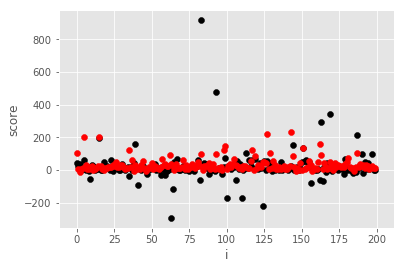

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 174315 to 267053
Data columns (total 18 columns):
tId                 250000 non-null int64
cId                 250000 non-null object
mob                 250000 non-null int64
vup                 250000 non-null int64
vdo                 250000 non-null int64
tit                 249994 non-null object
aut                 249986 non-null object
time                250000 non-null object
con                 250000 non-null object
time_since_epoch    250000 non-null float64
hour                250000 non-null int64
weekday             250000 non-null int64
weekday_fl          250000 non-null float64
is_answer           250000 non-null bool
con_len             250000 non-null int64
con_num_words       250000 non-null int64
score               250000 non-null int64
contr               250000 non-null int64
dtypes: bool(1), float64(2), int64(10), object(5)
memory usage: 34.6+ MB


In [38]:
X_res = []; y_pred = []; y_act = []
#for i, item in df.sample(200).iterrows():
#    y_pred.append(model.predict([item]))
#    y_act.append(item['score'])
#    X_res.append(i)
n = 200
sample = df.sample(n)
y_pred = model.predict(sample)
y_act = sample['score']
X_res = list(range(0, n))
    
plt.scatter(X_res, y_act, color='black')
plt.scatter(X_res, y_pred, color='red')
plt.xlabel('i'); plt.ylabel('score')
plt.show()

df_com.info()